In [1]:
from qbot.data.data_field import DataField
data_field = DataField(
    start_time='2024-01-01',
    end_time='2024-12-27'
)

Loading data from /Users/hsuh/Gitrepo/qbot-sdk2/qbot/data/BINANCE_1h_SPOT_ETHUSDT/2024-01-01_2024-12-27.parquet
Loading data from /Users/hsuh/Gitrepo/qbot-sdk2/qbot/data/BINANCE_1h_SPOT_BTCUSDT/2024-01-01_2024-12-27.parquet


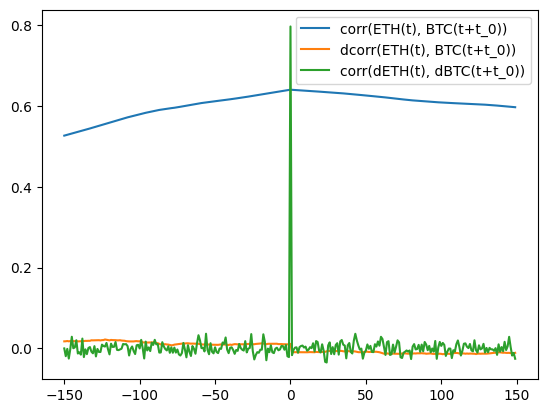

In [2]:
from qbot.strategy.utils import correlation_plot
correl_data, labels = correlation_plot(
    data_field['ETHUSDT']['close'],
    data_field['BTCUSDT']['close'],
    x_label='ETH',
    y_label='BTC'
)

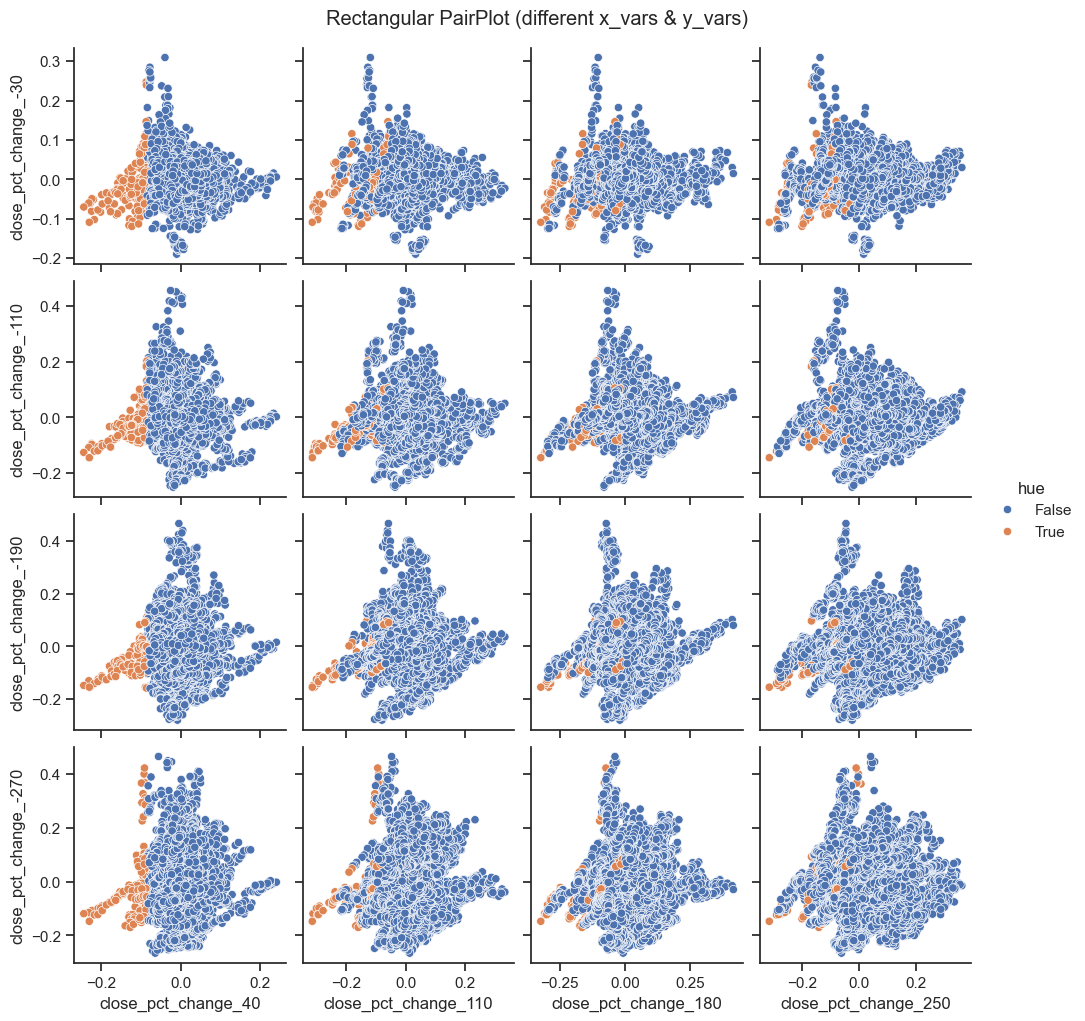

In [3]:
from qbot.strategy.utils import pairplot_scan
new_df = pairplot_scan(
    data_field['ETHUSDT'],
    x_col='close',
    y_col='close',
    x_shifts=range(40, 300, 70),
    y_shifts=range(-30, -300, -80),
    hue_func=lambda df: df['close_pct_change_40'] < -0.085,
)

In [4]:
from qbot.strategy.strategy import Strategy
import numpy as np

strategy = Strategy(name='226hETHLagging')

strategy.hyper_params = {
    'shift': 226,
    'weight_scale': 25.99348249,
    'weight_sigmoid_scale': 2.23440811,
    'weight_clip_lower': -0.55174966,
    'weight_clip_upper': 0.86291262,
    'beta_offset': -0.22802245,
    'beta_scale': 1.78955622
}

def weight_func(strategy, data_field):

    strategy.reference_index = 'ETHUSDT_close'
    strategy['ETHUSDT_close'] = data_field['ETHUSDT']['close']
    strategy['226h_pct_change'] = strategy['ETHUSDT_close'].pct_change(periods=226)
    strategy['ln_eth_price'] = np.log(strategy['ETHUSDT_close'])
    
    weight = strategy.hyper_params['weight_scale'] * strategy['226h_pct_change']
    weight = (strategy.hyper_params['weight_sigmoid_scale'] * 
                weight * (1/(1+np.exp(-weight))))
    weight = np.clip(
        weight,
        strategy.hyper_params['weight_clip_lower'],
        strategy.hyper_params['weight_clip_upper']
    )
    weight = weight - strategy.hyper_params['beta_offset']
    weight = weight * strategy.hyper_params['beta_scale']

    strategy['ETHUSDT_weight'] = weight

strategy.weight_func = weight_func
strategy.eval_weight(data_field)


In [5]:
strategy.eval_asset()
perf_dict, perf_str = strategy.eval_perf()
print(perf_str)

Total Return: 312.44%		ARR: 318.89%
ETHUSDT Return: 45.82%		ARR: 46.43%
Annual Ref Return * Beta:	ARR: 32.10%
-----------------------------------------
annual alpha: 288.42%, beta: 0.69, annual gamma: 0.68
Duration: 0.99 years		Max Drawdown: -45.88%
-----------------------------------------
Annual Sharpe Ratio:     	1.76
Annual Sortino Ratio:    	2.13
Annual Ref Sortino Ratio:	0.76



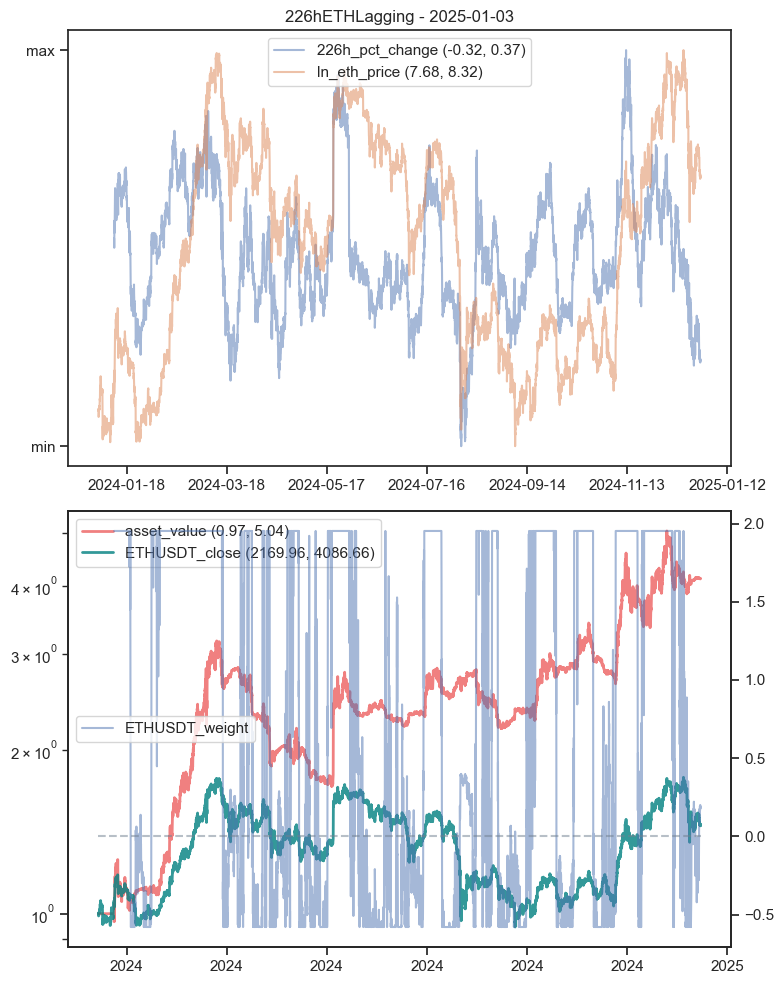

In [6]:
from matplotlib import pyplot as plt
fig, ax1, ax2 = strategy.plot_perf()
plt.savefig('example.png')